<a href="https://colab.research.google.com/github/StillWork/book7/blob/master/g_29_1_%EC%8B%9C%ED%80%80%EC%8A%A4%EC%98%88%EC%B8%A1%EB%B9%84%EA%B5%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시계열 예측 방법
- 랜덤 포레스트
- 선형 모델
- ARIMA
- MLP
- CNN
- RNN

## 예측 타입
- 단변수 예측
- 멀티스텝 예측
- 다중변수 예측
- 다중변수 멀티스텝 예측


In [1]:
%config InlineBackend.figure_format = 'retina'


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
# %tensorflow_version 2.x
from keras.layers import Dense
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU, LSTM
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
import keras
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter('ignore')
plt.rcParams['figure.dpi'] = 100

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## 데이터 다운로드

In [3]:
!curl -L https://goo.gl/s8qSL5  -o ./bike_train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  643k  100  643k    0     0   314k      0  0:00:02  0:00:02 --:--:--  314k


In [4]:
df = pd.read_csv("bike_train.csv", parse_dates=["datetime"])
df[:3]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


## 자전거 대여수 (시계열 데이터)

In [5]:
count = df["count"].values
print(count.shape)

(10886,)


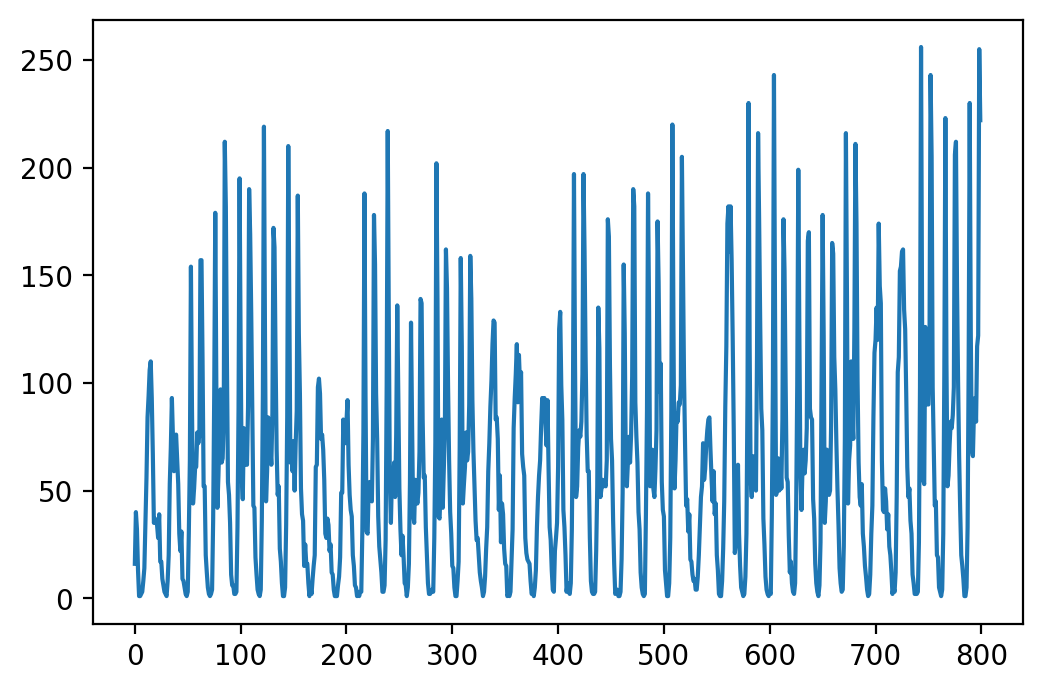

In [6]:
plt.plot(count[:800])

## 모든 특정을 사용한 머신러닝 방법의 성능
- 랜덤 포레스트

## datetime 날짜 데이터 분해

In [7]:
type(df['datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [8]:
df["d-year"] = df["datetime"].dt.year
df["d-month"] = df["datetime"].dt.month
df["d-day"] = df["datetime"].dt.day
df["d-hour"] = df["datetime"].dt.hour
df["d-dayofweek"] = df["datetime"].dt.dayofweek

df[["datetime", "d-year", "d-month", "d-day", "d-hour","d-dayofweek" ]].head()

,datetime,d-year,d-month,d-day,d-hour,d-dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,5
1,2011-01-01 01:00:00,2011,1,1,1,5
2,2011-01-01 02:00:00,2011,1,1,2,5
3,2011-01-01 03:00:00,2011,1,1,3,5
4,2011-01-01 04:00:00,2011,1,1,4,5


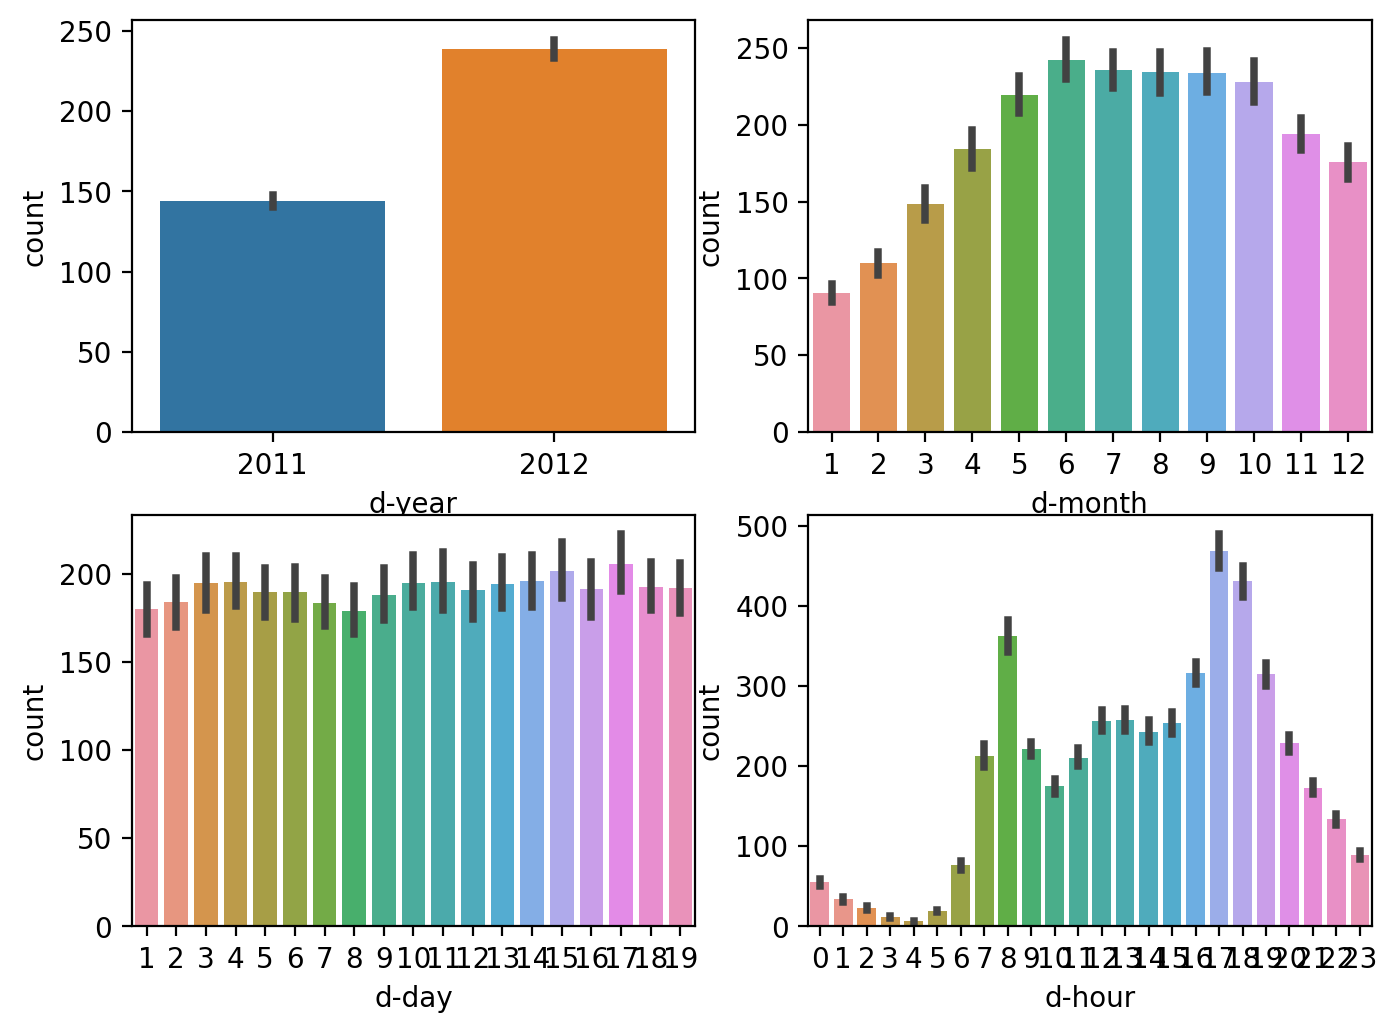

In [9]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
              figsize=(8,6))
sns.barplot(data=df, x="d-year", y="count", ax=ax1)
sns.barplot(data=df, x="d-month", y="count", ax=ax2)
sns.barplot(data=df, x="d-day", y="count", ax=ax3)
sns.barplot(data=df, x="d-hour", y="count", ax=ax4)

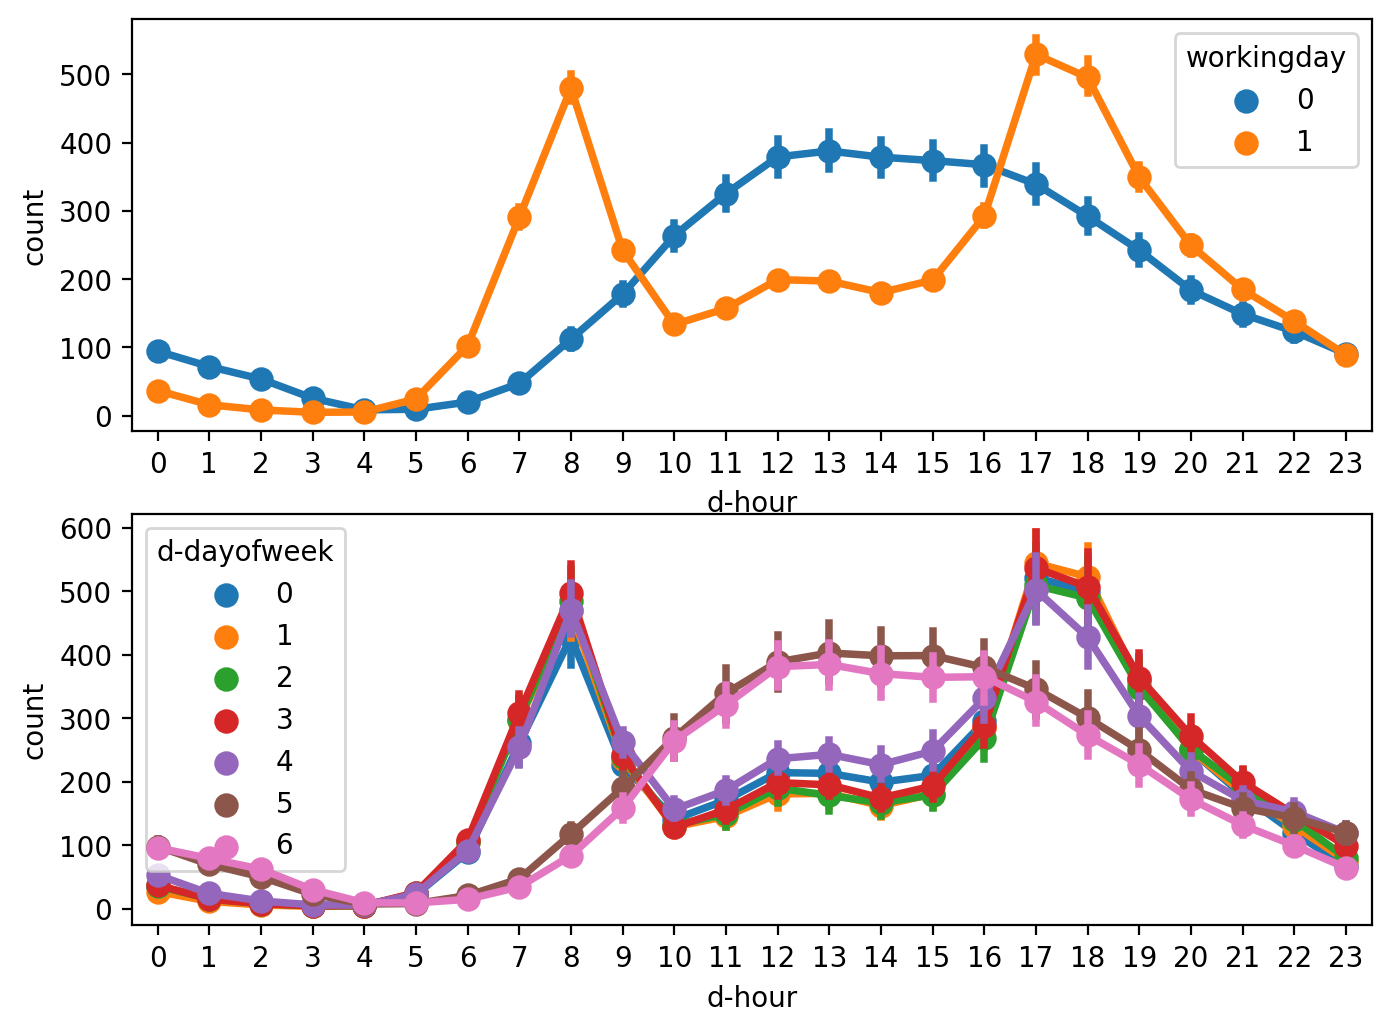

In [10]:
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(8, 6)

sns.pointplot(data=df, x="d-hour", y="count", hue="workingday", ax=ax1)
sns.pointplot(data=df, x="d-hour", y="count", hue="d-dayofweek", ax=ax2)

## 훈련에 사용할 특성 선택

In [11]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'd-year', 'd-month', 'd-day', 'd-hour', 'd-dayofweek'],
      dtype='object')

In [12]:
features = ["season", "holiday", "workingday", "weather", "temp", "atemp", 
            "humidity", "windspeed", "d-year", "d-hour", "d-dayofweek"]

In [13]:
features2 = ["season", "holiday", "workingday", "d-hour", "d-dayofweek"]

## 자전거 대여 수

In [14]:
X = df[features2]
y = count
X_train, X_test, y_train, y_test = train_test_split(X, y)

# 랜덤포레스트

In [15]:
model = RandomForestRegressor(n_estimators= 100)
model.fit(X_train, y_train)
model.score(X_test, y_test) # R2

0.7256692577921706

In [16]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test) # R2

0.7252640565773973

## 주요 특성 변수

In [17]:
def feature_importances_fig(features, importances):
    df = pd.DataFrame({'feature':features,'importance':importances})
    df = df.sort_values('importance', ascending=False)
    ypos = np.arange(len(df.feature))

    plt.figure(figsize=(6,4))
    plt.barh(df.feature, df.importance)
    plt.yticks(ypos, df.feature)
    plt.xlabel('Importance')
    plt.ylabel('Variable')
    plt.xlim(0, 1)
    plt.ylim(-1, len(df.feature))
    plt.show()

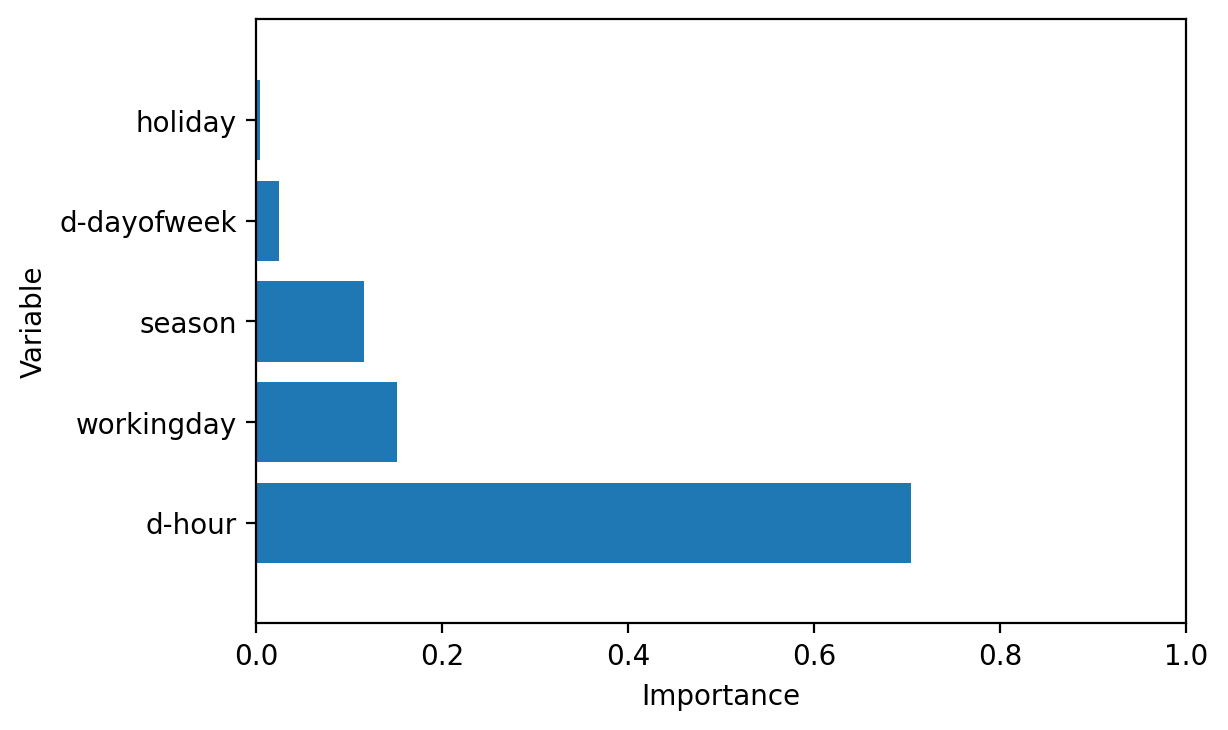

In [18]:
feature_importances_fig(features2, model.feature_importances_)

In [19]:
# 실제값과 예측치 비교
def plot_y_pred(y_test, y_pred):
    plt.figure(figsize=(8, 5))
    plt.plot(y_test, c='r')
    plt.plot(y_pred, c='b')
    plt.show()

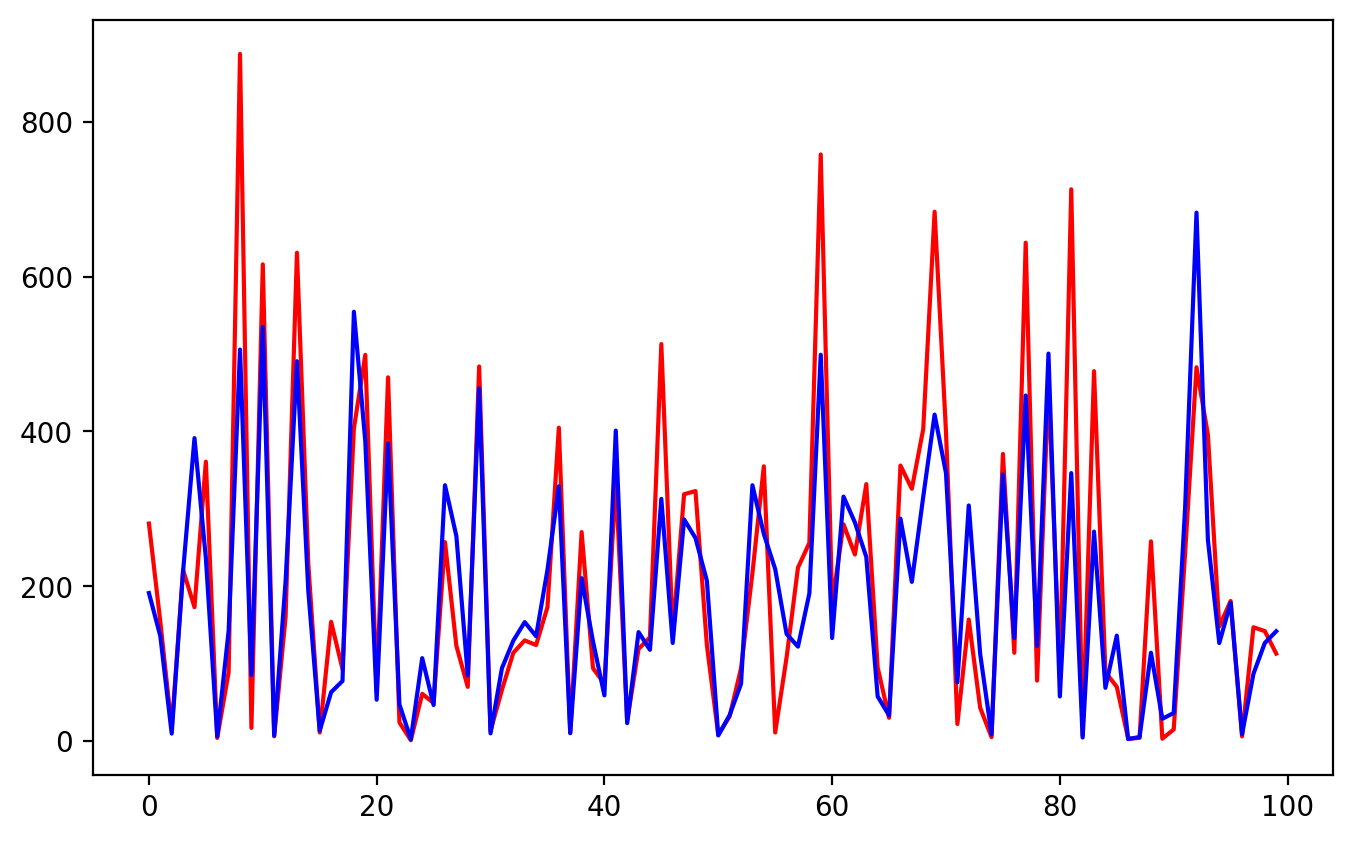

In [20]:
y_pred = model.predict(X_test)
plot_y_pred(y_test[:100], y_pred[:100])

In [21]:
np.vstack((y_test[:10], y_pred[:10].round(0))).T

array([[281., 191.],
       [154., 136.],
       [ 16.,  10.],
       [221., 219.],
       [173., 391.],
       [361., 236.],
       [  4.,   6.],
       [ 89., 142.],
       [888., 506.],
       [ 17.,  85.]])

In [22]:
def scatter_errors(y_test, y_pred):
    error = abs(y_test - y_pred)
    print("average=", error.mean())
    print("max=", max(error))
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test, error, s=2)

average= 62.10198979168027
max= 481.38461538461536


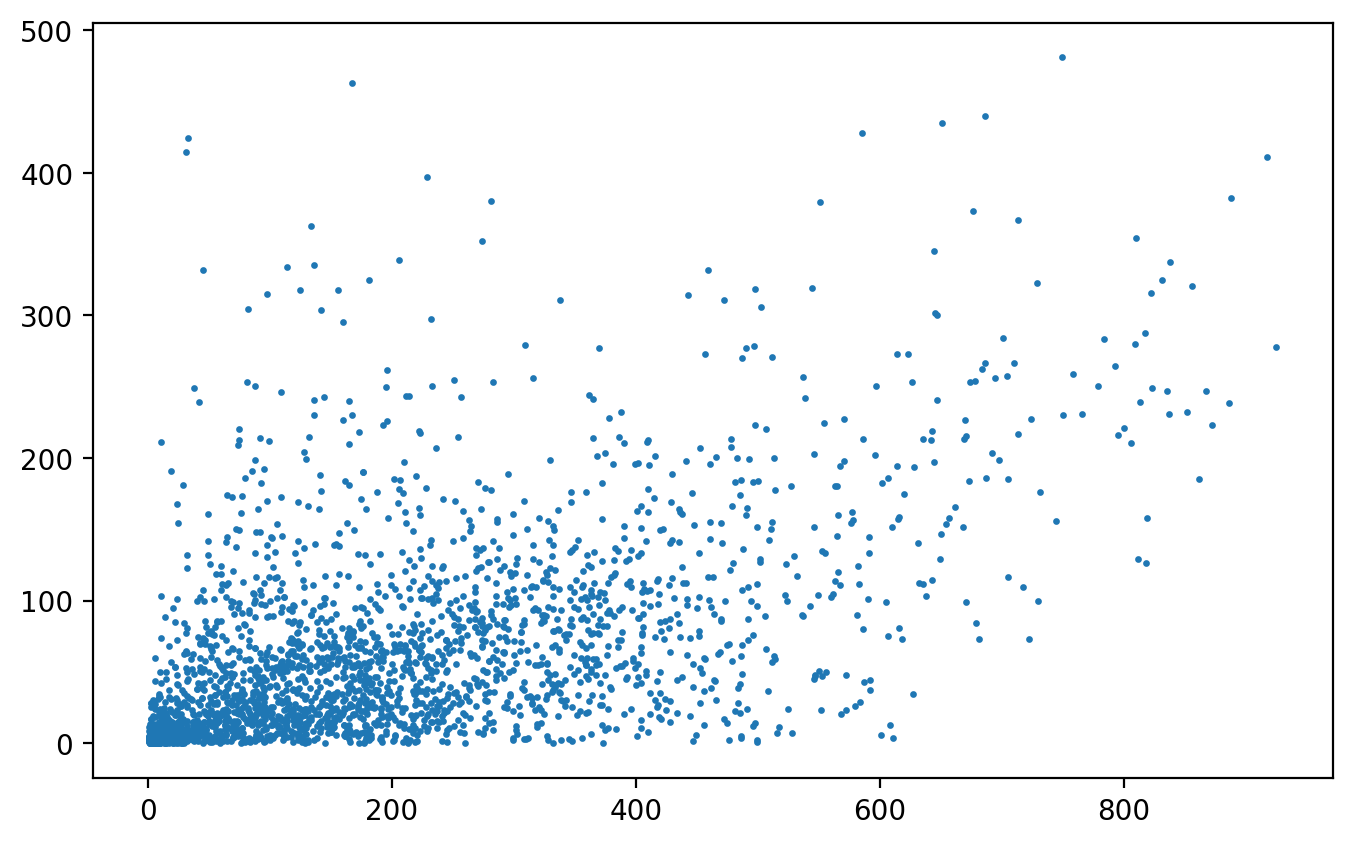

In [23]:
scatter_errors(y_test, y_pred)

# 단변수 예측 (univatiate)
## 선형 모델

In [24]:
count.shape

(10886,)

In [25]:
train = y[:7000]
test = y[7000:]

## 머신 러닝 모델에서 사용할 X, y 구조 생성

In [26]:
def split_data(data, n_steps):
    x, y = [], []
    for i in range(len(data)):
        if i > len(data) - n_steps - 1 : break
        x.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(x), np.array(y)

In [27]:
data = [1,2,3,4,5,6,7,8,9,10]
X_data, y_data = split_data(data, 3)
list(zip(X_data, y_data))

[(array([1, 2, 3]), 4),
 (array([2, 3, 4]), 5),
 (array([3, 4, 5]), 6),
 (array([4, 5, 6]), 7),
 (array([5, 6, 7]), 8),
 (array([6, 7, 8]), 9),
 (array([7, 8, 9]), 10)]

## 적절한 n_steps 찾기

In [28]:
for n_steps in range(1,24*30,24):
  train_x, train_y = split_data(train, n_steps)
  test_x, test_y = split_data(test, n_steps)
  lr= LinearRegression()
  lr.fit(train_x, train_y) 
  print(n_steps, lr.score(test_x, test_y).round(4))

1 0.6611
25 0.8681
49 0.8804
73 0.8855
97 0.8864
121 0.8892
145 0.8966
169 0.9013
193 0.9005
217 0.9015
241 0.902
265 0.9009
289 0.9011
313 0.9012
337 0.9013
361 0.9014
385 0.9023
409 0.9024
433 0.9023
457 0.9029
481 0.9025
505 0.9018
529 0.9015
553 0.901
577 0.9013
601 0.9015
625 0.9013
649 0.9011
673 0.8999
697 0.8992


In [29]:
n_steps = 10*24
train_x, train_y = split_data(train, n_steps)
test_x, test_y = split_data(test, n_steps)

0.9017100885901984


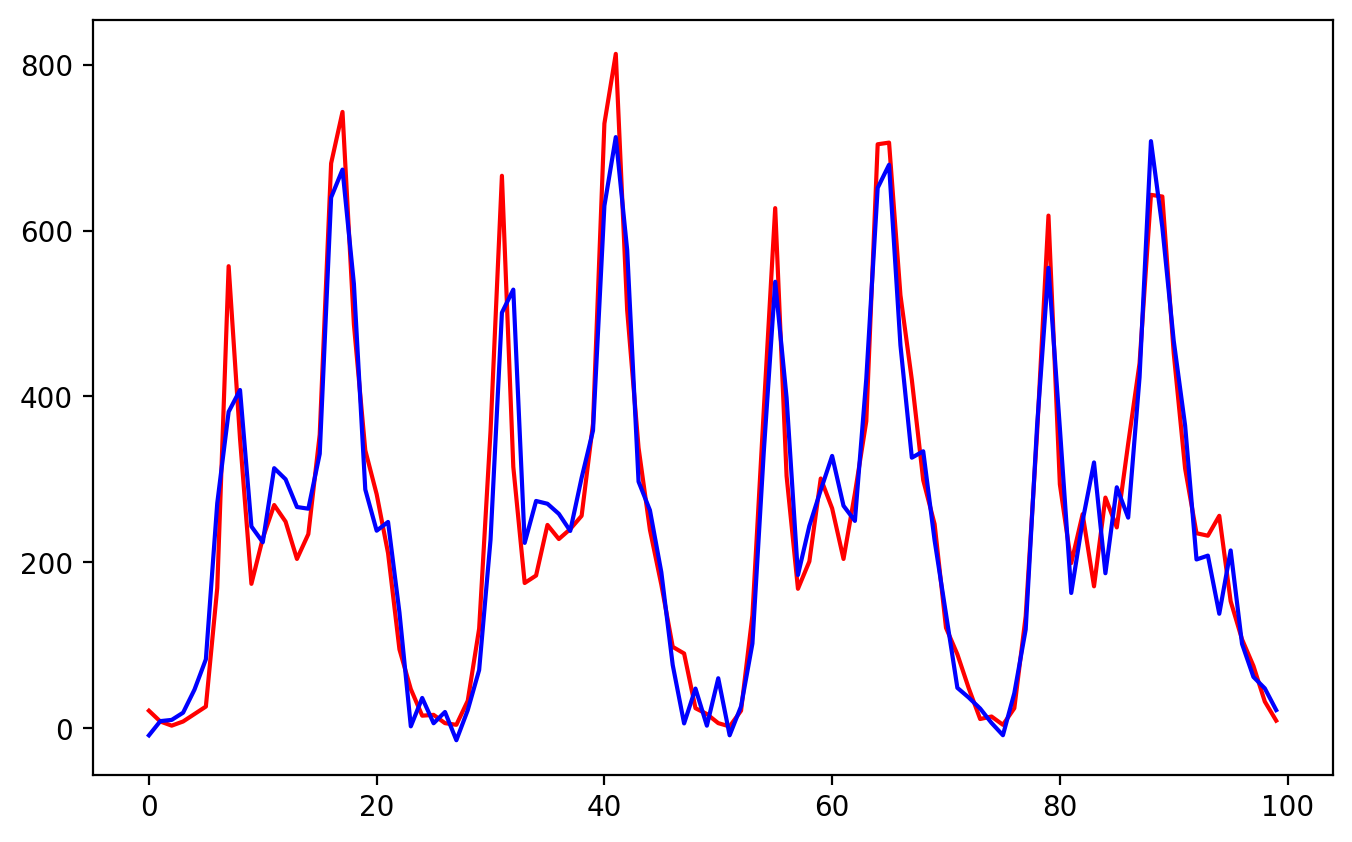

In [30]:
lr.fit(train_x, train_y) 
print(lr.score(test_x, test_y))
y_pred = lr.predict(test_x)
plot_y_pred(test_y[:100], y_pred[:100])

## 1시간 후를 예측했으므로 정확하다

average= 47.87395662710875
max= 468.6451264822009


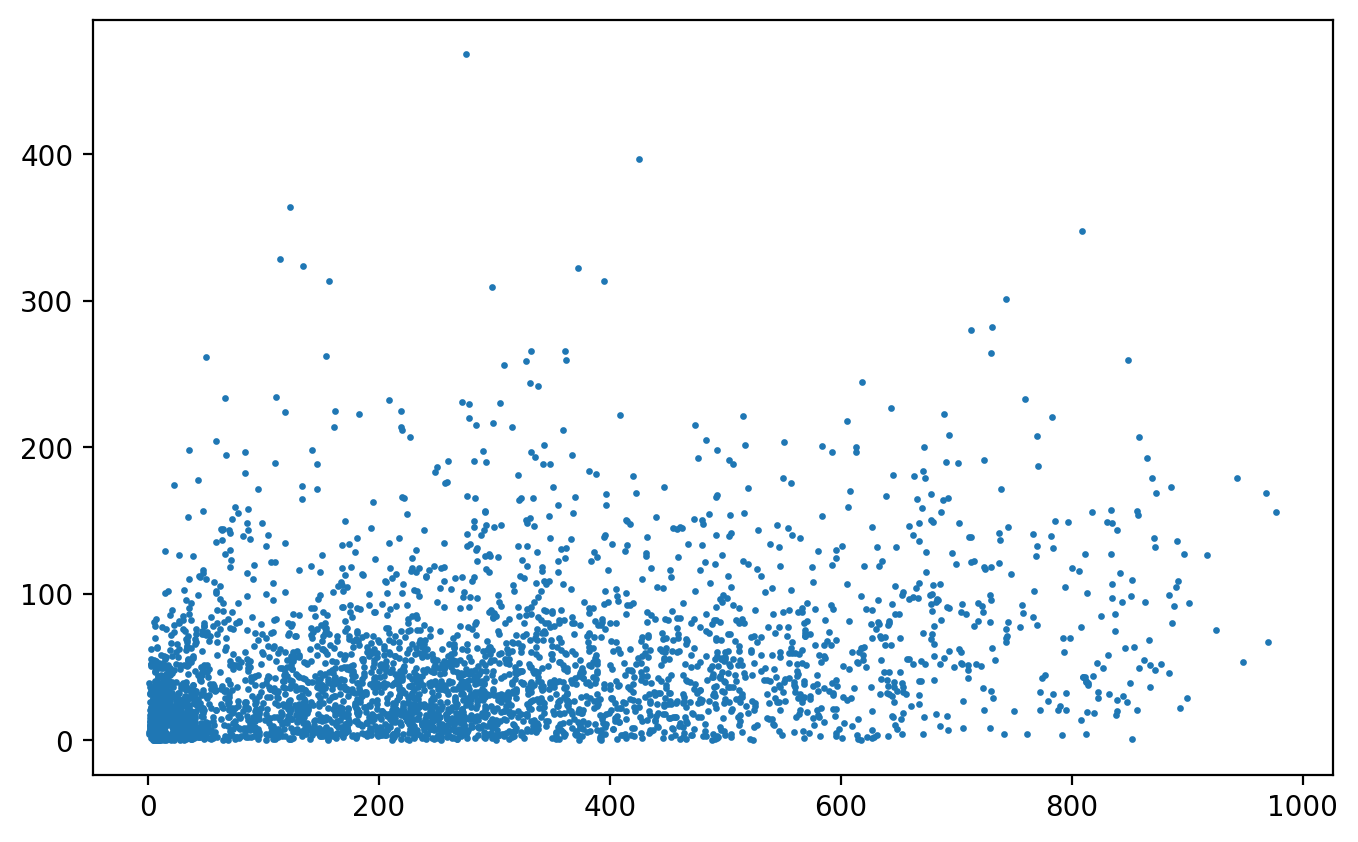

In [31]:
scatter_errors(test_y, y_pred)

## MLP (단변수)

In [ ]:
# n_steps = 24*10
# train_x, train_y = split_data(train, n_steps)
# test_x, test_y = split_data(test, n_steps)

In [32]:
model = Sequential()
model.add(Dense(300, activation='relu', input_dim=n_steps)) 
model.add(Dense(300, activation='relu'))
model.add(Dense(1))

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               72300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 162,901
Trainable params: 162,901
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(train_x,train_y, batch_size=20, epochs=30,
                                          validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Train on 5408 samples, validate on 1352 samples
Epoch 1/30
5408/5408 [==============================] - 1s 230us/step - loss: 1550.4119 - val_loss: 2354.3793
Epoch 2/30
5408/5408 [==============================] - 1s 192us/step - loss: 1394.2323 - val_loss: 2301.7113
Epoch 3/30
5408/5408 [==============================] - 1s 190us/step - loss: 1241.5372 - val_loss: 2313.5626
Epoch 4/30
5408/5408 [==============================] - 1s 188us/step - loss: 1122.4833 - val_loss: 2224.6386
Epoch 5/30
5408/5408 [==============================] - 1s 203us/step - loss: 1238.5167 - val_loss: 2210.8997
Epoch 6/30
5408/5408 [==============================] - 1s 197us/step - loss: 1067.3611 - val_loss: 1907.7713
Epoch 7/30
5408/5408 [==============================] - 1s 207us/step - loss: 1068.6005 - val_loss: 3685.1676
Epoch 8/30
5408/5408 [==============================] - 1s 200us/step - loss: 1126.4527 - val_loss: 1911.7154
Epoch 9/30
5408/5408 [==============================] - 1s 201us/step - 

In [36]:
y_pred = model.predict(test_x)
r2_score(test_y, y_pred)

0.9075303590190487

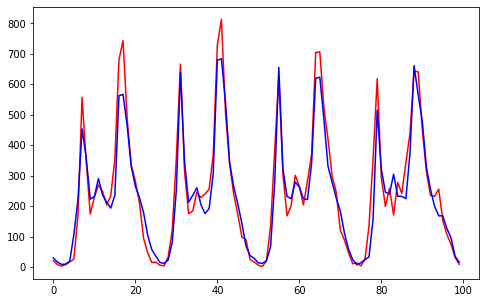

In [ ]:
plot_y_pred(test_y[:100], y_pred[:100])

average= 41.334184206356014
max= 426.30572509765625


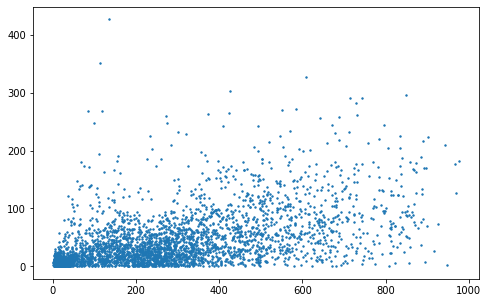

In [ ]:
scatter_errors(test_y, y_pred[:,0])

## CNN (단변수)

In [ ]:
n_steps =24*10
train_x, train_y = split_data(train, n_steps)
test_x, test_y = split_data(test, n_steps)

In [ ]:

model = Sequential()
model.add(Reshape((n_steps,1), input_shape=(n_steps,)))
model.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps,1))) 
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 2))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 240, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 239, 64)           192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 119, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 118, 64)           8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 58, 128)           16512     
_________________________________________________________________
flatten_1 (Flatten)          (None, 7424)             

In [ ]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(train_x, train_y, batch_size=20, epochs=200,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6)])

Train on 5408 samples, validate on 1352 samples
Epoch 1/200
5408/5408 [==============================] - 7s 1ms/step - loss: 7109.0333 - val_loss: 8859.6927
Epoch 2/200
5408/5408 [==============================] - 1s 217us/step - loss: 4016.6991 - val_loss: 6060.8061
Epoch 3/200
5408/5408 [==============================] - 1s 217us/step - loss: 3564.7564 - val_loss: 5823.3081
Epoch 4/200
5408/5408 [==============================] - 1s 219us/step - loss: 3080.4928 - val_loss: 6013.3033
Epoch 5/200
5408/5408 [==============================] - 1s 218us/step - loss: 2751.5128 - val_loss: 5032.2524
Epoch 6/200
5408/5408 [==============================] - 1s 217us/step - loss: 2566.9745 - val_loss: 4736.1351
Epoch 7/200
5408/5408 [==============================] - 1s 222us/step - loss: 2387.1575 - val_loss: 4687.7086
Epoch 8/200
5408/5408 [==============================] - 1s 217us/step - loss: 2231.4472 - val_loss: 4088.8447
Epoch 9/200
5408/5408 [==============================] - 1s 218us/

In [ ]:
y_pred = model.predict(test_x)
r2_score(test_y, y_pred)

0.8359500447748798

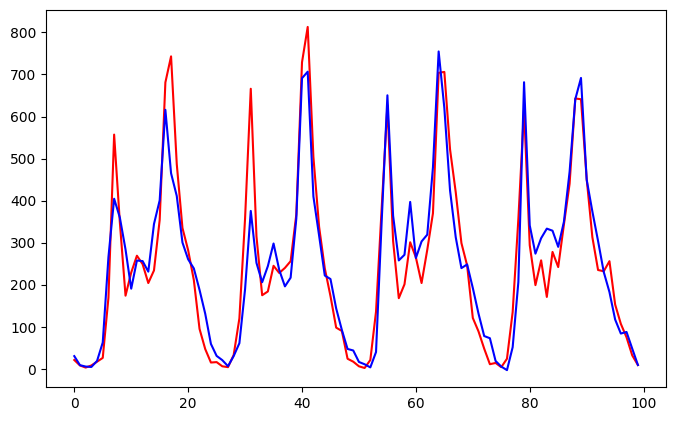

In [ ]:
plot_y_pred(test_y[:100], y_pred[:100])

average= 58.44968890043582
max= 557.0272216796875


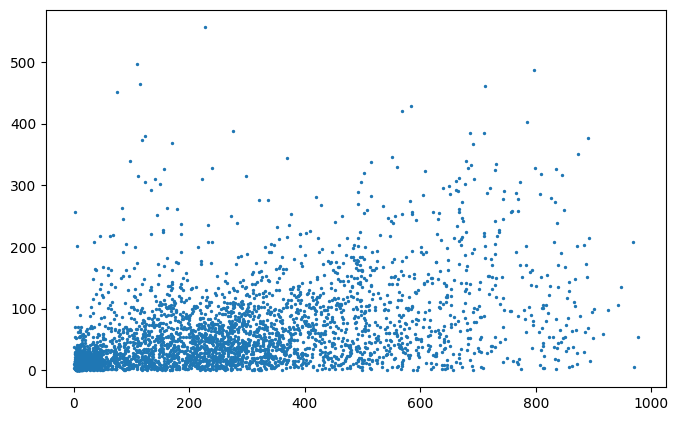

In [ ]:
scatter_errors(test_y, y_pred[:,0])

## RNN (단변수)

In [ ]:
n_steps =24
train_x, train_y = split_data(train, n_steps)
test_x, test_y = split_data(test, n_steps)

In [ ]:
model = Sequential()
model.add(Reshape((n_steps,1), input_shape=(n_steps,)))
model.add(GRU(64, activation='elu', input_shape=(n_timesteps, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# model.summary()

In [ ]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(train_x, train_y, batch_size=20, epochs=200,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)])

Train on 5580 samples, validate on 1396 samples
Epoch 1/200
5580/5580 [==============================] - 10s 2ms/step - loss: 6626.7047 - val_loss: 4939.1491
Epoch 2/200
5580/5580 [==============================] - 9s 2ms/step - loss: 2991.6224 - val_loss: 4678.6064
Epoch 3/200
5580/5580 [==============================] - 9s 2ms/step - loss: 2775.6752 - val_loss: 5206.4135
Epoch 4/200
5580/5580 [==============================] - 9s 2ms/step - loss: 2963.4634 - val_loss: 4449.8753
Epoch 5/200
5580/5580 [==============================] - 9s 2ms/step - loss: 2650.8985 - val_loss: 4498.3462
Epoch 6/200
5580/5580 [==============================] - 9s 2ms/step - loss: 2538.8617 - val_loss: 4071.0771
Epoch 7/200
5580/5580 [==============================] - 9s 2ms/step - loss: 2617.7353 - val_loss: 4522.1399
Epoch 8/200
5580/5580 [==============================] - 9s 2ms/step - loss: 2373.6923 - val_loss: 3468.7484
Epoch 9/200
5580/5580 [==============================] - 9s 2ms/step - loss: 22

In [ ]:
y_pred = model.predict(test_x)
r2_score(test_y, y_pred)

0.881981964159749

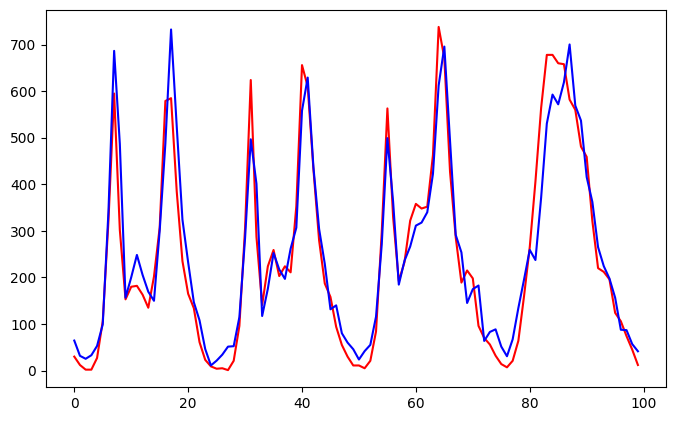

In [ ]:
plot_y_pred(test_y[:100], y_pred[:100])

average= 51.953741291608296
max= 526.6481018066406


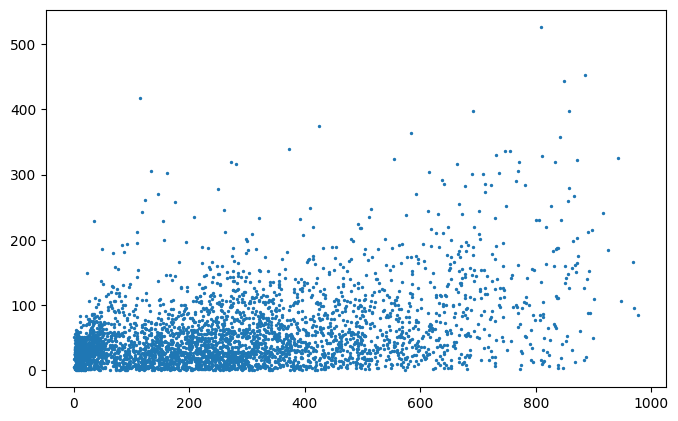

In [ ]:
scatter_errors(test_y, y_pred[:,0])

# 멀티 스텝 (univaiate)

## 멀티스텝 예측에 사용할 X, y 구조 생성

In [37]:
def split_sequence2(sequence, n_steps_in, n_steps_out):
  X, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # 마지막 값이 범위 내에 있는지 확인
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix-1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [38]:
data = [1,2,3,4,5,6,7,8,9,10]
n_steps_in, n_steps_out = 3, 5
X, y = split_sequence2(data, n_steps_in, n_steps_out)
for i in range(len(X)):
  print(X[i], y[i])

[1 2 3] 8
[2 3 4] 9
[3 4 5] 10


## 훈련 데이터와 테스트 데이터

In [40]:
train = count[:7000]
test = count[7000:]

In [41]:
train.shape, test.shape

((7000,), (3886,))

In [42]:
lr = LinearRegression()
n_steps = 24*10
for n_steps_out in [1,5,10,168]:
  train_x, train_y = split_sequence2(train, n_steps, n_steps_out)
  test_x, test_y = split_sequence2(test, n_steps, n_steps_out)
  lr.fit(train_x, train_y) 
  print(n_steps_out, ',', lr.score(test_x, test_y).round(3))

1 , 0.902
5 , 0.778
10 , 0.768
168 , 0.724


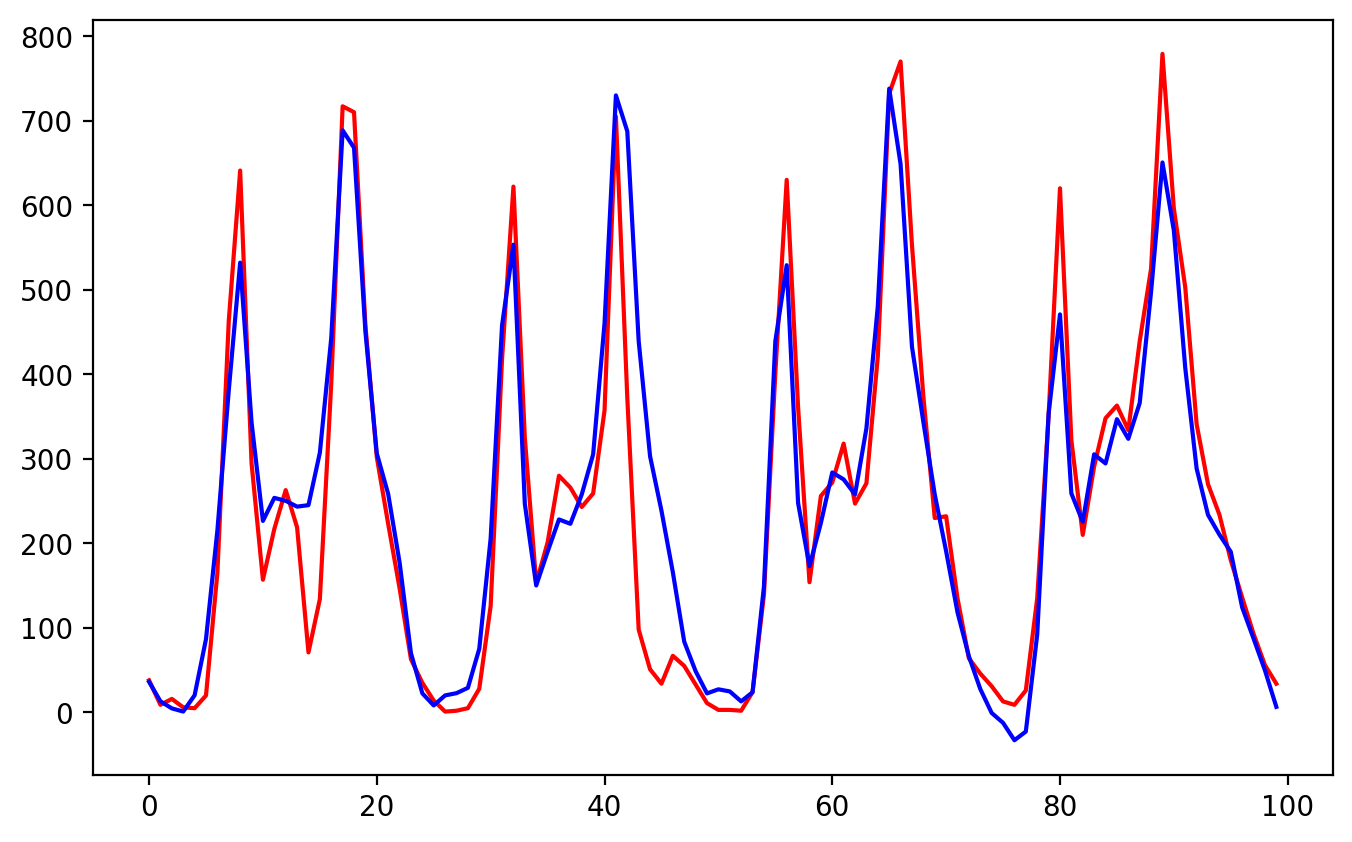

In [43]:
y_pred = lr.predict(test_x)
plot_y_pred(test_y[:100], y_pred[:100])

average= 82.17696896852357
max= 553.068294497697


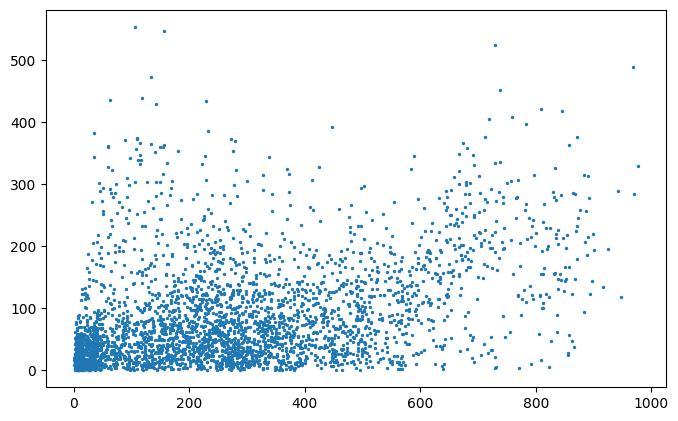

In [ ]:
scatter_errors(test_y, y_pred)

## MLP (멀티스텝)

In [44]:
model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(n_steps,))) 
model.add(Dense(300, activation='relu'))
model.add(Dense(1))

## 4가지 경우에 대한 R2

In [49]:
n_steps = 24*10
for n_steps_out in [1,5,10,168]:
  train_x, train_y = split_sequence2(train, n_steps, n_steps_out)
  test_x, test_y = split_sequence2(test, n_steps, n_steps_out)
  model.compile(loss='mse',optimizer='adam')
  history = model.fit(train_x,train_y, batch_size=20, epochs=30,
                            validation_split=0.2, verbose=1,
  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)])
  y_pred = model.predict(test_x)
  print("n_steps_out= ", n_steps_out ,"R2 = ", r2_score(test_y, y_pred))

Train on 5408 samples, validate on 1352 samples
Epoch 1/30
5408/5408 [==============================] - 1s 209us/step - loss: 2657.9538 - val_loss: 3836.8854
Epoch 2/30
5408/5408 [==============================] - 1s 193us/step - loss: 1542.6100 - val_loss: 2649.5602
Epoch 3/30
5408/5408 [==============================] - 1s 188us/step - loss: 1261.2728 - val_loss: 2649.6466
Epoch 4/30
5408/5408 [==============================] - 1s 190us/step - loss: 1180.7149 - val_loss: 2425.1971
Epoch 5/30
5408/5408 [==============================] - 1s 197us/step - loss: 1014.2834 - val_loss: 2211.4986
Epoch 6/30
5408/5408 [==============================] - 1s 206us/step - loss: 1020.6996 - val_loss: 2492.9458
Epoch 7/30
5408/5408 [==============================] - 1s 196us/step - loss: 973.2645 - val_loss: 2182.8896
Epoch 8/30
5408/5408 [==============================] - 1s 190us/step - loss: 896.8003 - val_loss: 2492.8092
Epoch 9/30
5408/5408 [==============================] - 1s 208us/step - lo

## RNN  (멀티스텝)

In [ ]:
n_steps =24*10
n_steps_out = 24*7
train_x, train_y = split_sequence(train, n_steps, n_steps_out)
test_x, test_y = split_sequence(test, n_steps, n_steps_out)

In [ ]:
model = Sequential()
model.add(Reshape((n_steps,1), input_shape=(n_steps,)))
model.add(GRU(64, activation='elu', input_shape=(n_timesteps, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(train_x, train_y, batch_size=20, epochs=200,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5274 samples, validate on 1319 samples
Epoch 1/200
5274/5274 [==============================] - 114s 22ms/step - loss: 9379.5351 - val_loss: 13963.3434
Epoch 2/200
5274/5274 [==============================] - 112s 21ms/step - loss: 7954.9590 - val_loss: 13144.6217
Epoch 3/200
5274/5274 [==============================] - 115s 22ms/step - loss: 7754.0400 - val_loss: 13901.5416
Epoch 4/200
5274/5274 [==============================] - 114s 22ms/step - loss: 7732.4957 - val_loss: 13340.4054
Epoch 5/200
5274/5274 [==============================] - 114s 22ms/step - loss: 7782.8047 - val_loss: 12948.8644
Epoch 6/200
5274/5274 [==============================] - 114s 22ms/step - loss: 7587.6694 - val_loss: 13078.1773
Epoch 7/200
5274/5274 [==============================] - 113s 21ms/step - loss: 7549.4775 - val_loss: 12419.5394
Epoch 8/200
5274/5274 [==============================] - 110s 21ms/

In [ ]:
y_pred = model.predict(test_x)
r2_score(test_y, y_pred)

0.881981964159749

# 다중변수 예측 (멀티 스텝) - 옵션

In [ ]:
features = ["count", "temp", "humidity","season", "workingday",  "d-year", "d-hour"]
continuous_features = ["count", "temp", "humidity"]
discrete_features = ["season", "workingday", "d-year", "d-hour"]
X2 = df[features]

In [ ]:
X2.nunique()

count         822
temp           49
humidity       89
season          4
workingday      2
d-year          2
d-hour         24
dtype: int64

In [ ]:
X = pd.get_dummies(X2, columns = discrete_features)
X[:3]

,count,temp,humidity,season_1,season_2,season_3,season_4,workingday_0,workingday_1,d-year_2011,d-year_2012,d-hour_0,d-hour_1,d-hour_2,d-hour_3,d-hour_4,d-hour_5,d-hour_6,d-hour_7,d-hour_8,d-hour_9,d-hour_10,d-hour_11,d-hour_12,d-hour_13,d-hour_14,d-hour_15,d-hour_16,d-hour_17,d-hour_18,d-hour_19,d-hour_20,d-hour_21,d-hour_22,d-hour_23
0,16,9.84,81,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40,9.02,80,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,32,9.02,80,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sc = StandardScaler()
X[continuous_features] = sc.fit_transform(X[continuous_features])
X[:3]

,count,temp,humidity,season_1,season_2,season_3,season_4,workingday_0,workingday_1,d-year_2011,d-year_2012,d-hour_0,d-hour_1,d-hour_2,d-hour_3,d-hour_4,d-hour_5,d-hour_6,d-hour_7,d-hour_8,d-hour_9,d-hour_10,d-hour_11,d-hour_12,d-hour_13,d-hour_14,d-hour_15,d-hour_16,d-hour_17,d-hour_18,d-hour_19,d-hour_20,d-hour_21,d-hour_22,d-hour_23
0,-0.969294,-1.333661,0.993213,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.836797,-1.438907,0.941249,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.880962,-1.438907,0.941249,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 표준 스케일링 변수 (표준편차와 평균)
sc.scale_, sc.mean_

(array([181.13613357,   7.79123196,  19.24414932]),
 array([191.57413191,  20.23085982,  61.88645967]))

In [ ]:
count_sigma = sc.scale_[0]
count_mean = sc.mean_[0]
count_sigma, count_mean

(181.1361335742659, 191.57413191254824)

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # 마지막 값이 범위 내에 있는지 확인
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix-1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
train = X[:7000].values
test = X[7000:].values

In [ ]:
train.shape, test.shape

((7000, 35), (3886, 35))

In [ ]:
n_steps = 24*10
n_steps_out = 24 * 7
train_x, train_y = split_sequence(train, n_steps, n_steps_out)
test_x, test_y = split_sequence(test, n_steps, n_steps_out)

In [ ]:
train_x.shape, train_y.shape

((6593, 240, 35), (6593, 35))

In [ ]:
train_y = train_y[:,0]
test_y = test_y[:,0]

In [ ]:
train_x.shape, train_y.shape

((6593, 240, 35), (6593,))

In [ ]:
n_features = train_x.shape[-1]
n_features

35

## MLP (다중변수 멀티스텝)

In [ ]:
model = Sequential()
model.add(Reshape((n_steps*n_features,), input_shape=(n_steps, n_features))) 
model.add(Dense(300, activation='relu', input_shape=(n_steps*n_features,))) 
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(1))


In [ ]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(train_x,train_y, batch_size=20, epochs=200,
                                          validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)])





Train on 5274 samples, validate on 1319 samples
Epoch 1/200





5274/5274 [==============================] - 4s 709us/step - loss: 0.3073 - val_loss: 1.0833
Epoch 2/200
5274/5274 [==============================] - 3s 502us/step - loss: 0.2107 - val_loss: 0.8722
Epoch 3/200
5274/5274 [==============================] - 3s 503us/step - loss: 0.1830 - val_loss: 0.9357
Epoch 4/200
5274/5274 [==============================] - 3s 496us/step - loss: 0.1554 - val_loss: 0.9156
Epoch 5/200
5274/5274 [==============================] - 3s 494us/step - loss: 0.1328 - val_loss: 0.8992
Epoch 6/200
5274/5274 [==============================] - 3s 495us/step - loss: 0.1217 - val_loss: 0.9209
Epoch 7/200
5274/5274 [==============================] - 3s 496us/step - loss: 0.1110 - val_loss: 1.1274
Epoch 8/200
5274/5274 [==============================] - 3s 494us/step - loss: 0.0952 - val_loss: 1.2446


0.5782436772344566


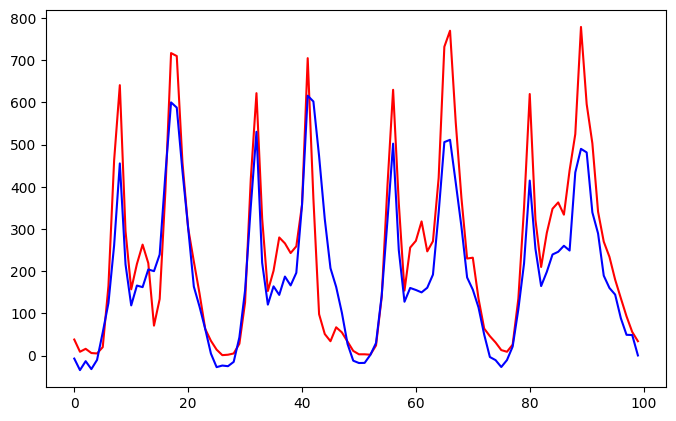

In [ ]:
y_pred = model.predict(test_x)
print(r2_score(test_y, y_pred))
plot_y_pred(test_y[:100]*count_sigma+count_mean, y_pred[:100]*count_sigma+count_mean)

In [ ]:
count_mean

191.57413191254824

average= 102.99036624795508
max= 595.6167449951172


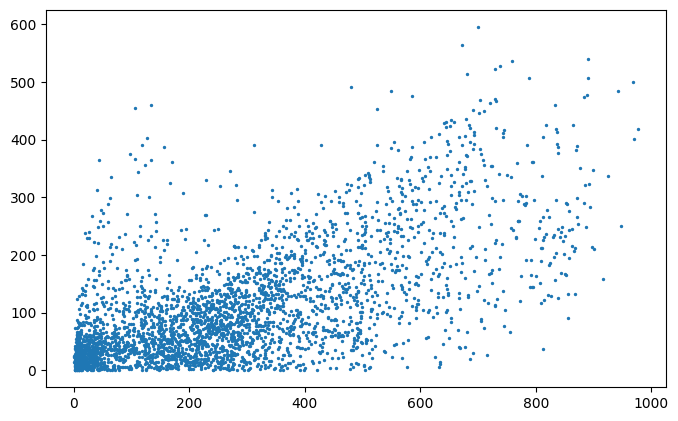

In [ ]:
scatter_errors(test_y*count_sigma+count_mean, y_pred[:,0]*count_sigma+count_mean)

## CNN (다중변수 멀티스텝)

In [ ]:
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps,n_features))) 
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 2))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 2))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 2))
model.add(MaxPooling1D(2))
model.add(Conv1D(256, 2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 239, 64)           4544      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 119, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 118, 64)           8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 58, 128)           16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 128)           0         
___

In [ ]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(train_x, train_y, batch_size=20, epochs=200,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)])

Train on 5274 samples, validate on 1319 samples
Epoch 1/200
5274/5274 [==============================] - 5s 954us/step - loss: 0.3403 - val_loss: 0.5221
Epoch 2/200
5274/5274 [==============================] - 3s 504us/step - loss: 0.2459 - val_loss: 0.6799
Epoch 3/200
5274/5274 [==============================] - 3s 556us/step - loss: 0.2166 - val_loss: 0.6948
Epoch 4/200
5274/5274 [==============================] - 3s 593us/step - loss: 0.2019 - val_loss: 0.6717
Epoch 5/200
5274/5274 [==============================] - 3s 596us/step - loss: 0.1948 - val_loss: 0.6001
Epoch 6/200
5274/5274 [==============================] - 3s 596us/step - loss: 0.1862 - val_loss: 0.7001
Epoch 7/200
5274/5274 [==============================] - 3s 596us/step - loss: 0.1743 - val_loss: 0.6060


0.6184726244327661


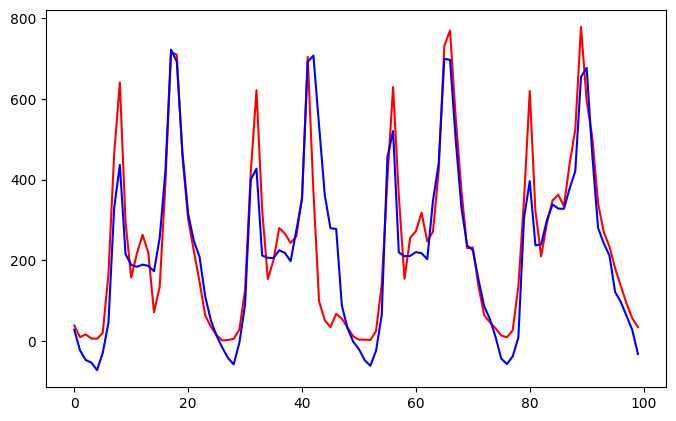

In [ ]:
y_pred = model.predict(test_x)
print(r2_score(test_y, y_pred))
plot_y_pred(test_y[:100]*count_sigma+count_mean, y_pred[:100]*count_sigma+count_mean)

average= 97.03804135630959
max= 612.9048919677734


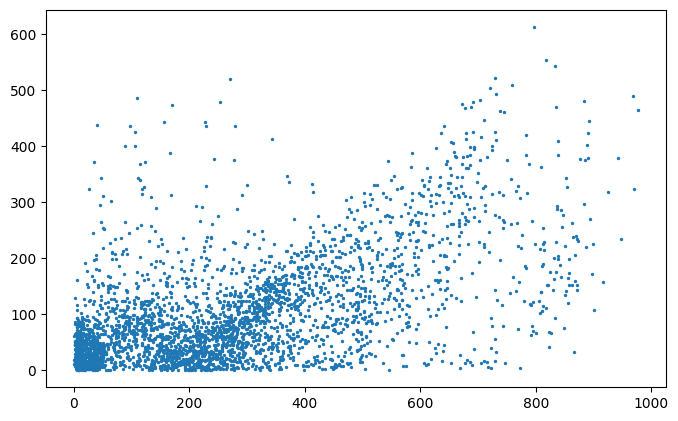

In [ ]:
scatter_errors(test_y*count_sigma+count_mean, y_pred[:,0]*count_sigma+count_mean)

## RNN (다중변수 멀티스텝)

In [ ]:
features = ["count", "temp", "d-hour"]
continuous_features = ["count", "temp"]
discrete_features = ["d-hour"]
# X2 = df["count"]
X2 = df[features]

In [ ]:
X2.nunique()

count     822
temp       49
d-hour     24
dtype: int64

In [ ]:
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 240, 64)           17472     
_________________________________________________________________
dropout_1 (Dropout)          (None, 240, 64)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 42,305
Trainable params: 42,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(train_x, train_y, batch_size=20, epochs=200,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5389 samples, validate on 1348 samples
Epoch 1/200
5389/5389 [==============================] - 228s 42ms/step - loss: 0.2324 - val_loss: 0.3429
Epoch 2/200
5389/5389 [==============================] - 229s 42ms/step - loss: 0.1833 - val_loss: 0.3668
Epoch 3/200
5389/5389 [==============================] - 228s 42ms/step - loss: 0.1784 - val_loss: 0.3135
Epoch 4/200
5389/5389 [==============================] - 227s 42ms/step - loss: 0.1755 - val_loss: 0.3282
Epoch 5/200
5389/5389 [==============================] - 227s 42ms/step - loss: 0.1729 - val_loss: 0.3156
Epoch 6/200
5389/5389 [==============================] - 229s 43ms/step - loss: 0.1722 - val_loss: 0.3171
Epoch 7/200
5389/5389 [==============================] - 232s 43ms/step - loss: 0.1698 - val_loss: 0.3330
Epoch 8/200
5389/5389 [==============================] - 230s 43ms/step - loss: 0.1701 - val_loss: 0.3122
Epoch 9/20

0.5583290483214496


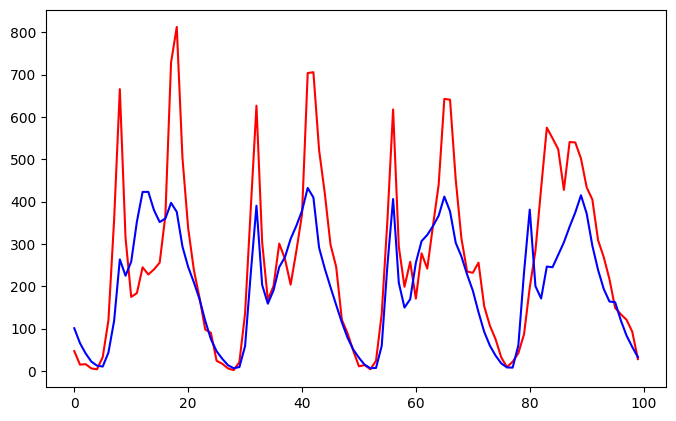

In [ ]:
y_pred = model.predict(test_x)
print(r2_score(test_y, y_pred))
plot_y_pred(test_y[:100]*count_sigma+count_mean, y_pred[:100]*count_sigma+count_mean)

average= 99.66713782196508
max= 629.3436889648438


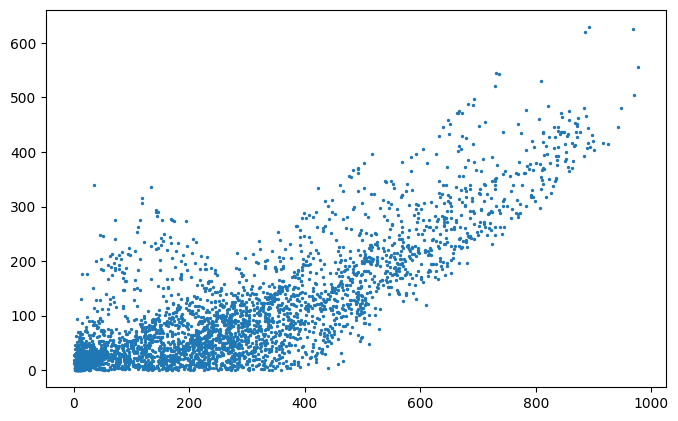

In [ ]:
scatter_errors(test_y*count_sigma+count_mean, y_pred[:,0]*count_sigma+count_mean)

In [ ]:
features = ["count", "temp", "humidity","season", "workingday",  "d-year", "d-hour"]
continuous_features = ["count", "temp", "humidity"]
discrete_features = ["season", "workingday", "d-year", "d-hour"]
X2 = df[features]

In [ ]:
X2.nunique()

count         822
temp           49
humidity       89
season          4
workingday      2
d-year          2
d-hour         24
dtype: int64

In [ ]:
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 240, 64)           19200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 240, 64)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 44,033
Trainable params: 44,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(train_x, train_y, batch_size=20, epochs=200,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)])

Train on 5274 samples, validate on 1319 samples
Epoch 1/200
5274/5274 [==============================] - 252s 48ms/step - loss: 0.2907 - val_loss: 0.6047
Epoch 2/200
5274/5274 [==============================] - 252s 48ms/step - loss: 0.2175 - val_loss: 0.5104
Epoch 3/200
5274/5274 [==============================] - 256s 49ms/step - loss: 0.2055 - val_loss: 0.5384
Epoch 4/200
5274/5274 [==============================] - 255s 48ms/step - loss: 0.2017 - val_loss: 0.5026
Epoch 5/200
5274/5274 [==============================] - 251s 48ms/step - loss: 0.1959 - val_loss: 0.5235
Epoch 6/200
5274/5274 [==============================] - 253s 48ms/step - loss: 0.1905 - val_loss: 0.5440
Epoch 7/200
5274/5274 [==============================] - 251s 48ms/step - loss: 0.1865 - val_loss: 0.5497
Epoch 8/200
5274/5274 [==============================] - 252s 48ms/step - loss: 0.1861 - val_loss: 0.5443
Epoch 9/200
5274/5274 [==============================] - 252s 48ms/step - loss: 0.1775 - val_loss: 0.531

0.42197701176059


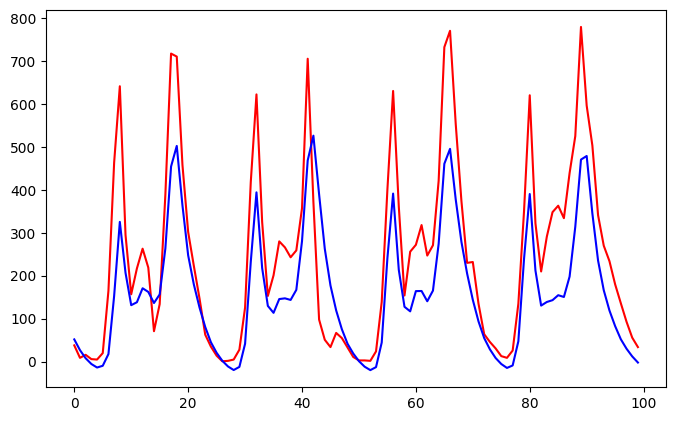

In [ ]:
y_pred = model.predict(test_x)
print(r2_score(test_y, y_pred))
plot_y_pred(test_y[:100]*count_sigma+count_mean, y_pred[:100]*count_sigma+count_mean)

average= 120.74321902966697
max= 638.1828918457031


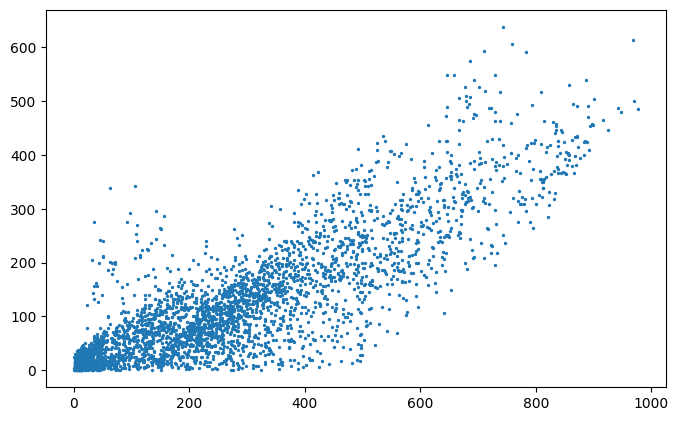

In [ ]:
scatter_errors(test_y*count_sigma+count_mean, y_pred[:,0]*count_sigma+count_mean)

## 개선된 모델 (R squared: 0.7)

In [ ]:
model = Sequential()
model.add(SimpleRNN(256, activation='elu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.3))
model.add(SimpleRNN(128, activation='elu', return_sequences=True))
model.add(Dropout(0.3))
model.add(SimpleRNN(64, activation='elu'))
model.add(Dense(1))